In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델 및 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
#토크나이저 -> 형태소 분석 => 정수 인코딩
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
#           분류모델
# down-stream 작업 : 사전학습 모델을 불러온 후 추가로 처리하고자 하는 작업 = 파인튜닝

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model
# (classifier): Linear(in_features=768, out_features=3, bias=True)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [4]:
import torch

# 긍정/부정 데이터셋 준비
dic = {0: 'posivie', 1: 'neutral', 2: 'negative'}
eval_list = ['I like apple',
             'I like pear',
             'I go to school',
             'I dislike mosquito',
             'I felt very sad',
             'I feel so good']

ans = torch.tensor([0,0,1,2,2,0])

In [18]:
# 파인 튜닝을 하지 않고 테스트
model.eval()
# 결과만 확인하기 위해 빈리스트 생성
predicted_results = []

with torch.no_grad():
    for article in eval_list:
        inputs = tokenizer.encode(article, return_tensors='pt', padding=True, truncation=True)
        print(inputs)
        outputs = model(inputs)
        print(outputs)
        logits = outputs.logits
        print(f"{dic[logits.argmax(-1).item()]} : {article}")
        # 추가 #
        predicted_label = logits.argmax(-1).item()
        predicted_results.append((article, dic[predicted_label]))
    print('=' * 50)
for article, prediction in predicted_results:
    print(f"Prediction: {prediction} | Article: {article}")

tensor([[  101,   146,  1176, 12075,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4318,  0.7718, -0.9293]]), hidden_states=None, attentions=None)
neutral : I like apple
tensor([[  101,   146,  1176,   185, 19386,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3099,  0.8144, -0.8673]]), hidden_states=None, attentions=None)
neutral : I like pear
tensor([[ 101,  146, 1301, 1106, 1278,  102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4183,  0.7622, -0.9533]]), hidden_states=None, attentions=None)
neutral : I go to school
tensor([[  101,   146, 20662,   182,  2155, 21594,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3922,  0.8232, -0.9084]]), hidden_states=None, attentions=None)
neutral : I dislike mosquito
tensor([[ 101,  146, 1464, 1304, 6782,  102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4543,  0.6065, -0.8943]]), hidden_states=None, attentions=None)
neutral : I felt very sad
tensor([[ 101,  146, 1631, 

▲ 모든 결과가 중립으로 나타남, 학습이 필요한 상태임

In [21]:
# 학습모드 => model.train()
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

optimizer = AdamW(model.parameters(), lr=1e-5)
model.train()

epochs = 50
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    inputs = tokenizer.batch_encode_plus(eval_list, return_tensors='pt', padding=True, truncation=True)
    # 미니배치로 여러개 한꺼번에
    outputs = model(**inputs, labels=ans) # ** 딕셔너리
    logits = outputs.logits
    loss = outputs.loss

    # 오차역전파
    loss.backward()

    # 가중치(weight) 업데이트
    optimizer.step()
    losses.append(loss)

    # 추가 #
    # 정확도 계산
    predicted_labels = np.argmax(logits.detach().cpu().numpy(), axis=1)
    true_labels = ans.detach().cpu().numpy()
    accuracy = accuracy_score(true_labels, predicted_labels)

    # F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # print(f'epoch: {epoch+1}, loss:{loss}')
    print(f'epoch: {epoch+1}, loss:{loss:.4f}, Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}')

epoch: 1, loss:0.0473, Accuracy: 1.0000, F1 score: 1.0000
epoch: 2, loss:0.0504, Accuracy: 1.0000, F1 score: 1.0000
epoch: 3, loss:0.0468, Accuracy: 1.0000, F1 score: 1.0000
epoch: 4, loss:0.0442, Accuracy: 1.0000, F1 score: 1.0000
epoch: 5, loss:0.0421, Accuracy: 1.0000, F1 score: 1.0000
epoch: 6, loss:0.0499, Accuracy: 1.0000, F1 score: 1.0000
epoch: 7, loss:0.0399, Accuracy: 1.0000, F1 score: 1.0000
epoch: 8, loss:0.0416, Accuracy: 1.0000, F1 score: 1.0000
epoch: 9, loss:0.0387, Accuracy: 1.0000, F1 score: 1.0000
epoch: 10, loss:0.0389, Accuracy: 1.0000, F1 score: 1.0000
epoch: 11, loss:0.0359, Accuracy: 1.0000, F1 score: 1.0000
epoch: 12, loss:0.0464, Accuracy: 1.0000, F1 score: 1.0000
epoch: 13, loss:0.0301, Accuracy: 1.0000, F1 score: 1.0000
epoch: 14, loss:0.0296, Accuracy: 1.0000, F1 score: 1.0000
epoch: 15, loss:0.0275, Accuracy: 1.0000, F1 score: 1.0000
epoch: 16, loss:0.0259, Accuracy: 1.0000, F1 score: 1.0000
epoch: 17, loss:0.0263, Accuracy: 1.0000, F1 score: 1.0000
epoch:

In [22]:
new_losses = [i.item() for i in losses]

In [24]:
new_losses

[0.04725749418139458,
 0.050399523228406906,
 0.0467742383480072,
 0.04416678845882416,
 0.04209035262465477,
 0.04987900331616402,
 0.03990262746810913,
 0.04163069650530815,
 0.03871798515319824,
 0.03887121006846428,
 0.03586837649345398,
 0.04638320207595825,
 0.03011794202029705,
 0.029647981747984886,
 0.027545394375920296,
 0.025865109637379646,
 0.02634836919605732,
 0.03127655014395714,
 0.028184248134493828,
 0.024696098640561104,
 0.028467630967497826,
 0.025271952152252197,
 0.023766981437802315,
 0.022214293479919434,
 0.02149777114391327,
 0.01983286254107952,
 0.020885713398456573,
 0.02092609368264675,
 0.019680391997098923,
 0.017359301447868347,
 0.018020842224359512,
 0.01972913183271885,
 0.020620863884687424,
 0.01666112244129181,
 0.01828535459935665,
 0.01844356395304203,
 0.01629849709570408,
 0.01634804904460907,
 0.020543240010738373,
 0.01800663396716118,
 0.015576477162539959,
 0.015635965391993523,
 0.01533252838999033,
 0.015223967842757702,
 0.01200956106

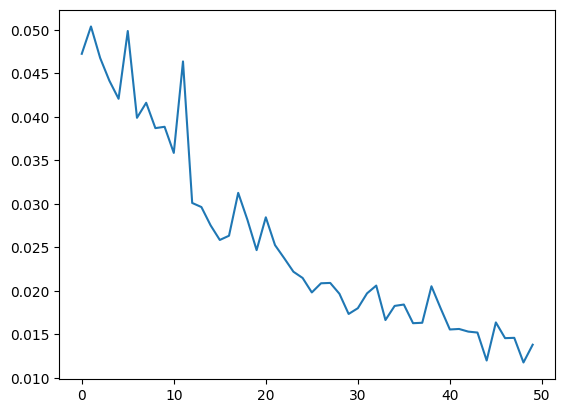

In [23]:
# loss값 시각화
import matplotlib.pyplot as plt
plt.plot(new_losses)

In [25]:
# 파인튜닝 이후 추론
dic = {0: 'positive', 1: 'neutral', 2: 'negative'}

eval_list = ['I like apple',
             'I like pear',
             'I go to school',
             'I dislike mosquito',
             'I felt very sad',
             'I feel so good']

model.eval()
preds = []

with torch.no_grad():
    for article in eval_list:
        inputs = tokenizer.encode(article, return_tensors='pt', padding=True, truncation=True)
        outputs = model(inputs)
        logits = outputs.logits
        pred = logits.argmax(-1).item()
        preds.append(logits.argmax(-1).item())
        print(f'{dic[pred]}: {article}')

positive: I like apple
positive: I like pear
neutral: I go to school
negative: I dislike mosquito
negative: I felt very sad
positive: I feel so good


In [26]:
import torch
preds = torch.tensor(preds)
preds

tensor([0, 0, 1, 2, 2, 0])

In [27]:
print(f"Accuracy: {100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy: 100.0%


In [28]:
ans

tensor([0, 0, 1, 2, 2, 0])